# New York City Crime

<img src=images/banner.jpg/ width="600">

# Overview

The purpose of this project is to create a predictive **model to predict crime in New York City**. This model will assist the New York Police Department (NYPD) to combat crime by providing predictions of future daily crime incident reports. Utilizing this tool, the executive staff can determine a future plan for officers to prevent future crime or stop future crime as soon as possible. To create this model, I used a dataset from NYC Open Data of all valid felony, misdemeanor, and violation crimes reported to the NYPD from 2006 to the end of 2023. The final model is a **Random Forest Regressor** with an **RMSE of approximately 115** and **R2 score of approximately 0.64**.

# Business Understanding

New York City crime has gone through cycles. After the 2020 pandemic, many spoke about the increase in crime and the lack of enforcement against criminal behavior. The New York City Police Department (NYPD) is the largest and one of the oldest municipal police departments in the United States. The NYPD polices a city of approximately 8.5 million people. The purpose of this project is to **assist the NYPD keep crime levels low** through machine learning. I will do this **by creating a regressor model to predict daily reported crime incidents in New York City**. 

The stakeholders for this project include the New York City Police Commissioner and the Board of Commissioners. With an understanding of crime trends and future crime predictions, the executive staff can determine a future plan for officers to prevent future crime or intercept future crime as soon as possible.

In this project, I will complete the following 3 tasks:
1. **Analyze** crime trends in historical New York City crime data.
2. Create a random forest regressor model to **predict** daily reported crime incidents in New York city.
3. **Evaluate** the random forest regressor model and recommend next steps for the New York City Police Department.

# Data Understanding

The [data](https://data.cityofnewyork.us/Public-Safety/NYPD-Complaint-Data-Historic/qgea-i56i/about_data) has been extracted from NYC Open Data. It includes all valid felony, misdemeanor, and violation crimes reported to the New York City Police Department (NYPD) from 2006 to the end of 2023. There are 8,914,838 complaints reported. The data has 35 columns with reported information regarding each incident. The column descriptions can be found on the [data page](https://data.cityofnewyork.us/Public-Safety/NYPD-Complaint-Data-Historic/qgea-i56i/data_preview). 

After exploring the data, I resampled the data to include the number of reported crime incidents per day. I used this resampeld data, `data_daily`, to create the predictive model.

First, I import all the necessary libraries for EDA, data cleaning and modeling.

In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")
import random

from sklearn.model_selection import TimeSeriesSplit, train_test_split, RandomizedSearchCV
from sklearn.metrics import mean_squared_error, accuracy_score, r2_score

from sklearn.ensemble import RandomForestRegressor

from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import acf, pacf, adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX

random.seed(28)

In [2]:
# Import NYPD crime data and preview the first 5 rows to ensure it was imported correctly
data = pd.read_csv('data/NYPD_Complaint_Data_Historic_20241022.csv')
data.head()

/var/folders/pn/v9tvzf9s5ms7zcp53821ct0m0000gn/T/ipykernel_59016/1856452097.py:2: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv('data/NYPD_Complaint_Data_Historic_20241022.csv')


,CMPLNT_NUM,CMPLNT_FR_DT,CMPLNT_FR_TM,CMPLNT_TO_DT,CMPLNT_TO_TM,ADDR_PCT_CD,RPT_DT,KY_CD,OFNS_DESC,PD_CD,...,SUSP_SEX,TRANSIT_DISTRICT,Latitude,Longitude,Lat_Lon,PATROL_BORO,STATION_NAME,VIC_AGE_GROUP,VIC_RACE,VIC_SEX
0,25640826H10611,12/05/2006,10:38:00,NaN,(null),NaN,12/05/2006,101,MURDER & NON-NEGL. MANSLAUGHTER,NaN,...,(null),NaN,NaN,NaN,NaN,PATROL BORO QUEENS NORTH,(null),25-44,WHITE HISPANIC,M
1,16631501H8965,08/25/1973,12:15:00,NaN,(null),NaN,05/29/2006,101,MURDER & NON-NEGL. MANSLAUGHTER,NaN,...,(null),NaN,NaN,NaN,NaN,PATROL BORO MAN NORTH,(null),45-64,BLACK,F
2,11118212H8714,04/22/2006,16:50:00,NaN,(null),NaN,04/22/2006,101,MURDER & NON-NEGL. MANSLAUGHTER,NaN,...,(null),NaN,NaN,NaN,NaN,PATROL BORO BKLYN SOUTH,(null),45-64,BLACK,M
3,23471265H9399,07/20/2006,22:37:00,NaN,(null),NaN,07/20/2006,101,MURDER & NON-NEGL. MANSLAUGHTER,NaN,...,(null),NaN,NaN,NaN,NaN,PATROL BORO BKLYN SOUTH,(null),18-24,BLACK,M
4,24565927H10142,04/14/2006,02:37:00,NaN,(null),NaN,04/14/2006,101,MURDER & NON-NEGL. MANSLAUGHTER,NaN,...,(null),NaN,NaN,NaN,NaN,PATROL BORO BKLYN NORTH,(null),45-64,BLACK,M


# Data Preparation and Exploratory Data Analysis

To determine how to best go about modeling the data, I used various graphs to explore the features and to explore the reported crime incidents in different time spans - ie. yearly, monthly, weekly, daily. Many of the features proved to be useless, as the number of null values were greater than the actual values. When exploring `data.info()`, most columns appear to not have any null values. However, pon further exploration, many of tose string values state 'null'. This was true in cases such as suspect and victim race, age and sex. 

Additionally, the various columns that pertain to the location of the reported crime incident were not always accurate. According to the data footnotes, rape and sex crime offenses have been located as occurring at the police station house within the precinct of occurrence to protect victim identities. Additionally, many offenses that were not able to be geo-coded have been located as the police house within the precinct of occurense, offense in open areas have been located as the bordering street or intersection, and offese on moving trains have been located as the following train stop. 

In [3]:
# View the overall shape, dtypes and null counts for each column in train data
data.info(verbose=True, show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8914838 entries, 0 to 8914837
Data columns (total 35 columns):
 #   Column             Non-Null Count    Dtype  
---  ------             --------------    -----  
 0   CMPLNT_NUM         8914838 non-null  object 
 1   CMPLNT_FR_DT       8914183 non-null  object 
 2   CMPLNT_FR_TM       8914838 non-null  object 
 3   CMPLNT_TO_DT       7095880 non-null  object 
 4   CMPLNT_TO_TM       8914838 non-null  object 
 5   ADDR_PCT_CD        8914067 non-null  float64
 6   RPT_DT             8914838 non-null  object 
 7   KY_CD              8914838 non-null  int64  
 8   OFNS_DESC          8914838 non-null  object 
 9   PD_CD              8907245 non-null  float64
 10  PD_DESC            8914838 non-null  object 
 11  CRM_ATPT_CPTD_CD   8914838 non-null  object 
 12  LAW_CAT_CD         8914838 non-null  object 
 13  BORO_NM            8914838 non-null  object 
 14  LOC_OF_OCCUR_DESC  8914604 non-null  object 
 15  PREM_TYP_DESC      8914838 non-n

In [4]:
# Convert 'CMPLNT_NUM' to string
data['CMPLNT_NUM'] = data['CMPLNT_NUM'].astype(str)

# Check for duplicates using 'CMPLNT_NUM'
data['CMPLNT_NUM'].duplicated().value_counts()

# View duplicate rows
data[data['CMPLNT_NUM'].duplicated(keep=False) == True].sort_values('CMPLNT_NUM', axis=0)

,CMPLNT_NUM,CMPLNT_FR_DT,CMPLNT_FR_TM,CMPLNT_TO_DT,CMPLNT_TO_TM,ADDR_PCT_CD,RPT_DT,KY_CD,OFNS_DESC,PD_CD,...,SUSP_SEX,TRANSIT_DISTRICT,Latitude,Longitude,Lat_Lon,PATROL_BORO,STATION_NAME,VIC_AGE_GROUP,VIC_RACE,VIC_SEX
463904,10007381,01/04/2006,07:45:00,01/04/2006,07:47:00,107.0,01/04/2006,109,GRAND LARCENY,438.0,...,M,NaN,40.708070,-73.812293,"(40.70807, -73.812293)",PATROL BORO QUEENS SOUTH,(null),25-44,WHITE HISPANIC,F
466739,10007381,01/04/2006,07:45:00,01/04/2006,07:47:00,107.0,01/04/2006,109,GRAND LARCENY,438.0,...,M,NaN,40.730113,-73.810909,"(40.7301130668694, -73.8109089148815)",PATROL BORO QUEENS SOUTH,(null),25-44,WHITE HISPANIC,F
164552,10008294,01/01/2006,16:30:00,01/01/2006,16:35:00,63.0,01/01/2006,578,HARRASSMENT 2,637.0,...,(null),NaN,40.628170,-73.941359,"(40.6281697437036, -73.9413587834752)",PATROL BORO BKLYN SOUTH,(null),25-44,ASIAN / PACIFIC ISLANDER,M
249295,10008294,01/01/2006,16:30:00,01/01/2006,16:35:00,63.0,01/01/2006,578,HARRASSMENT 2,637.0,...,(null),NaN,40.612661,-73.912395,"(40.612661, -73.912395)",PATROL BORO BKLYN SOUTH,(null),25-44,ASIAN / PACIFIC ISLANDER,M
226425,10008686,07/23/2004,00:01:00,08/16/2005,00:01:00,77.0,01/06/2006,112,THEFT-FRAUD,489.0,...,(null),NaN,40.668438,-73.924120,"(40.668438, -73.92412)",PATROL BORO BKLYN NORTH,(null),25-44,BLACK,F
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
378931,9966757,12/15/2005,11:00:00,NaN,(null),75.0,01/03/2006,353,UNAUTHORIZED USE OF A VEHICLE,462.0,...,M,NaN,40.671360,-73.881811,"(40.6713598203364, -73.8818110231735)",PATROL BORO BKLYN NORTH,(null),18-24,BLACK,F
41523,9966791,01/04/2006,08:55:00,01/04/2006,09:00:00,76.0,01/04/2006,361,OFF. AGNST PUB ORD SENSBLTY &,639.0,...,(null),NaN,40.683691,-74.000504,"(40.683691, -74.000504)",PATROL BORO BKLYN SOUTH,(null),18-24,BLACK,F
48564,9966791,01/04/2006,08:55:00,01/04/2006,09:00:00,76.0,01/04/2006,361,OFF. AGNST PUB ORD SENSBLTY &,639.0,...,(null),NaN,40.683651,-74.000304,"(40.6836512406856, -74.0003043120176)",PATROL BORO BKLYN SOUTH,(null),18-24,BLACK,F
95765,9966968,01/04/2006,15:25:00,01/04/2006,15:35:00,88.0,01/04/2006,106,FELONY ASSAULT,109.0,...,M,NaN,40.688671,-73.977719,"(40.688671, -73.977719)",PATROL BORO BKLYN NORTH,(null),25-44,BLACK,F


In [5]:
# Drop duplicates
data = data.drop_duplicates(subset='CMPLNT_NUM')

In [7]:
# Create column with year of complaint
data['Year'] = data['CMPLNT_FR_DT'].apply(lambda x: str(x)[-4:])
data['Year'].value_counts()

Year
2023    543331
2007    535485
2022    529839
2006    529161
2008    528967
         ...  
1938         1
1951         1
1928         1
1930         1
1013         1
Name: count, Length: 121, dtype: int64

In [8]:
data[data['Year'] == 'nan']

,CMPLNT_NUM,CMPLNT_FR_DT,CMPLNT_FR_TM,CMPLNT_TO_DT,CMPLNT_TO_TM,ADDR_PCT_CD,RPT_DT,KY_CD,OFNS_DESC,PD_CD,...,TRANSIT_DISTRICT,Latitude,Longitude,Lat_Lon,PATROL_BORO,STATION_NAME,VIC_AGE_GROUP,VIC_RACE,VIC_SEX,Year
6455,11053532,NaN,03:45:00,04/23/2006,04:50:00,122.0,04/23/2006,341,PETIT LARCENY,321.0,...,NaN,40.558768,-74.169395,"(40.558768, -74.169395)",PATROL BORO STATEN ISLAND,(null),18-24,WHITE,M,nan
7606,10919210,NaN,09:00:00,NaN,(null),120.0,04/04/2006,361,OFF. AGNST PUB ORD SENSBLTY &,639.0,...,NaN,40.636810,-74.118650,"(40.63681, -74.11865)",PATROL BORO STATEN ISLAND,(null),18-24,WHITE HISPANIC,F,nan
13170,26098474,NaN,11:30:00,12/24/2006,12:20:00,120.0,12/24/2006,344,ASSAULT 3 & RELATED OFFENSES,113.0,...,NaN,40.614774,-74.083046,"(40.614774, -74.083046)",PATROL BORO STATEN ISLAND,(null),25-44,BLACK,M,nan
14046,10373963,NaN,09:02:00,NaN,(null),68.0,02/10/2006,578,HARRASSMENT 2,637.0,...,NaN,40.640211,-74.029741,"(40.640211, -74.029741)",PATROL BORO BKLYN SOUTH,(null),(null),UNKNOWN,M,nan
17850,25293635,NaN,13:39:00,NaN,(null),68.0,11/10/2006,106,FELONY ASSAULT,109.0,...,NaN,40.627488,-74.013928,"(40.627488, -74.013928)",PATROL BORO BKLYN SOUTH,(null),18-24,BLACK,M,nan
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4950009,145973350,NaN,09:00:00,NaN,(null),113.0,09/08/2015,109,GRAND LARCENY,424.0,...,NaN,40.682759,-73.767869,"(40.682759, -73.767869)",PATROL BORO QUEENS SOUTH,(null),25-44,BLACK,F,nan
4956791,144674119,NaN,19:10:00,07/20/2015,19:35:00,32.0,07/20/2015,578,HARRASSMENT 2,638.0,...,NaN,40.816002,-73.941332,"(40.816002, -73.941332)",PATROL BORO MAN NORTH,(null),25-44,BLACK,M,nan
4976132,145227904,NaN,19:30:00,NaN,(null),109.0,08/10/2015,361,OFF. AGNST PUB ORD SENSBLTY &,639.0,...,NaN,40.777608,-73.844347,"(40.777608, -73.844347)",PATROL BORO QUEENS NORTH,(null),25-44,WHITE HISPANIC,F,nan
5040256,143504462,NaN,13:30:00,06/06/2015,13:35:00,75.0,06/06/2015,578,HARRASSMENT 2,638.0,...,NaN,40.674375,-73.883560,"(40.674375, -73.88356)",PATROL BORO BKLYN NORTH,(null),18-24,ASIAN / PACIFIC ISLANDER,M,nan


In [11]:
# Drop rows where 'Year' is equal to 'nan'
data = data[data['Year'] != 'nan']

# Convert 'Year' to integer
data['Year'] = data['Year'].apply(lambda x: int(x))

# Keep entries only of year 2006 and later
data = data[data['Year']>=2006]

# View accurate years
data['Year'].value_counts()

Year
2023    543331
2007    535485
2022    529839
2006    529161
2008    528967
2009    511230
2010    510377
2012    505058
2011    498927
2013    496223
2014    492395
2015    479035
2016    478625
2017    468368
2018    462719
2019    459296
2021    449571
2020    413812
Name: count, dtype: int64

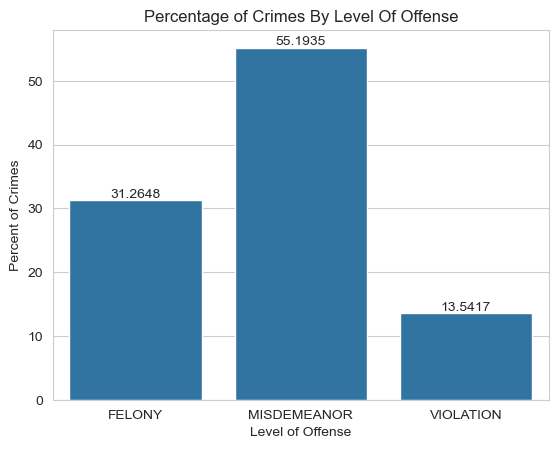

In [13]:
# Visualize crimes by level of offense
ax = sns.countplot(x="LAW_CAT_CD", data=data, stat='percent')
ax.set_xlabel('Level of Offense')
ax.set_ylabel('Percent of Crimes')
ax.set_title('Percentage of Crimes By Level Of Offense')
ax.bar_label(ax.containers[0]);

In [14]:
# View the different types of crime descriptions
data['OFNS_DESC'].value_counts()

OFNS_DESC
PETIT LARCENY                      1554436
HARRASSMENT 2                      1185843
ASSAULT 3 & RELATED OFFENSES        934685
CRIMINAL MISCHIEF & RELATED OF      875712
GRAND LARCENY                       778888
                                    ...   
FORTUNE TELLING                         13
ABORTION                                 7
OFFENSES AGAINST MARRIAGE UNCL           5
UNDER THE INFLUENCE OF DRUGS             3
KIDNAPPING AND RELATED OFFENSES          3
Name: count, Length: 73, dtype: int64

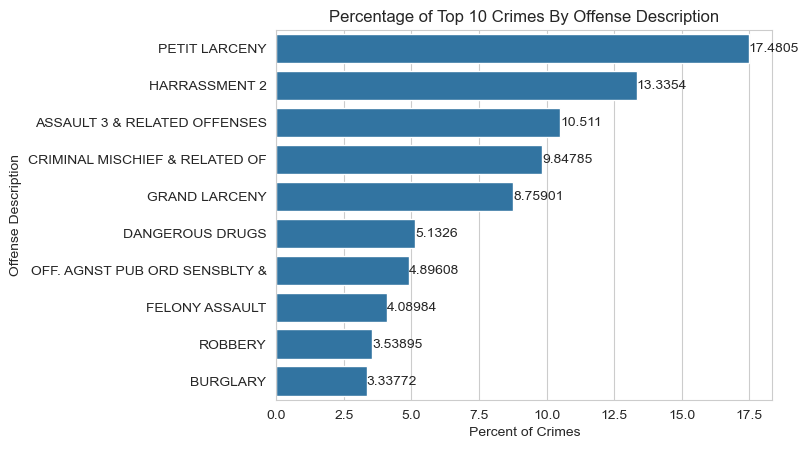

In [20]:
# Group the top 10 most frequent crime descriptions
top_10_off_desc = data.groupby('OFNS_DESC').size().sort_values(ascending=False).head(10)
top_10_off_desc

# Visualize crimes by offense description
ax = sns.countplot(data=data, 
                   y='OFNS_DESC', 
                   stat='percent',
                  order=data['OFNS_DESC'].value_counts(ascending=False).iloc[:10].index)
ax.set_xlabel('Percent of Crimes')
ax.set_ylabel('Offense Description')
ax.set_title('Percentage of Top 10 Crimes By Offense Description')
ax.bar_label(ax.containers[0]);

In [24]:
# Create and set datetime object
data['CMPLNT_FR_DT'] = pd.to_datetime(data['CMPLNT_FR_DT'], format='%m/%d/%Y')

# Set index as datetime
data = data.set_index(data['CMPLNT_FR_DT'], drop=True).sort_index()
data.head()

,CMPLNT_NUM,CMPLNT_FR_DT,CMPLNT_FR_TM,CMPLNT_TO_DT,CMPLNT_TO_TM,ADDR_PCT_CD,RPT_DT,KY_CD,OFNS_DESC,PD_CD,...,TRANSIT_DISTRICT,Latitude,Longitude,Lat_Lon,PATROL_BORO,STATION_NAME,VIC_AGE_GROUP,VIC_RACE,VIC_SEX,Year
CMPLNT_FR_DT,,,,,,,,,,,,,,,,,,,,,
2006-01-01,74871034,2006-01-01,13:00:00,06/01/2009,13:00:00,104.0,10/01/2010,109,GRAND LARCENY,438.0,...,NaN,40.730211,-73.900193,"(40.730211, -73.900193)",PATROL BORO QUEENS NORTH,(null),25-44,WHITE,M,2006
2006-01-01,10354063,2006-01-01,09:00:00,02/02/2006,10:00:00,109.0,02/09/2006,109,GRAND LARCENY,438.0,...,NaN,40.791826,-73.817909,"(40.791826, -73.817909)",PATROL BORO QUEENS NORTH,(null),45-64,WHITE HISPANIC,F,2006
2006-01-01,10007743,2006-01-01,15:30:00,01/04/2006,19:29:00,120.0,01/04/2006,361,OFF. AGNST PUB ORD SENSBLTY &,639.0,...,NaN,40.611535,-74.073754,"(40.611535, -74.073754)",PATROL BORO STATEN ISLAND,(null),45-64,WHITE,M,2006
2006-01-01,10008762,2006-01-01,01:00:00,NaN,(null),81.0,01/05/2006,578,HARRASSMENT 2,637.0,...,NaN,40.690653,-73.938073,"(40.690653, -73.938073)",PATROL BORO BKLYN NORTH,(null),25-44,BLACK,F,2006
2006-01-01,9934366,2006-01-01,03:00:00,NaN,(null),1.0,01/01/2006,344,ASSAULT 3 & RELATED OFFENSES,101.0,...,NaN,40.702840,-74.011919,"(40.70284, -74.011919)",PATROL BORO MAN SOUTH,(null),18-24,WHITE,M,2006


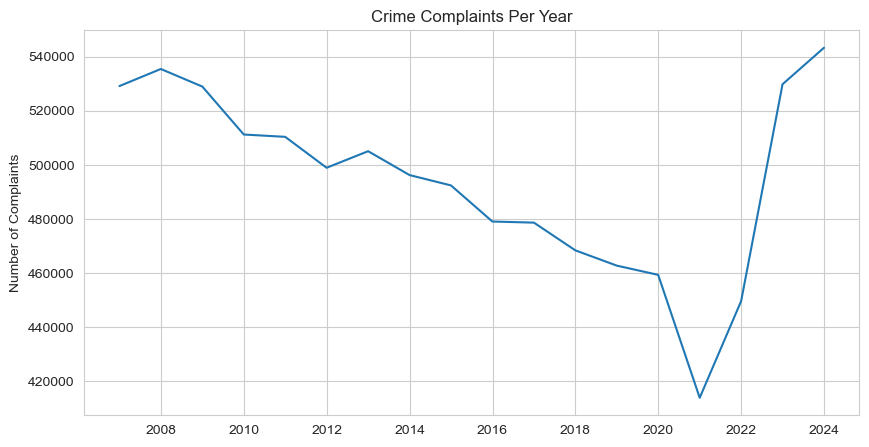

In [25]:
# Resample data to yearly and plot time series
fig, ax = plt.subplots(figsize=(10, 5))
data_yearly = data.resample('YE').count()['CMPLNT_FR_DT']
ax.plot(data_yearly.index, data_yearly.values)
ax.set_title('Crime Complaints Per Year')
ax.set_ylabel('Number of Complaints');

In [26]:
# Find min and max values
min_value = data_yearly.min()
max_value = data_yearly.max()

# Find corresponding years
min_year = data_yearly.idxmin().year
max_year = data_yearly.idxmax().year

print(f"Minimum complaints: {min_value} in {min_year}")
print(f"Maximum complaints: {max_value} in {max_year}")

Minimum complaints: 413812 in 2020
Maximum complaints: 543331 in 2023


Between the span of the years 2006 - 2023, the year 2020 held the minimum number of crime complaints at 423,812. Crime complaints in New York City had been declining since 2008, with a drastic decrease in 2020. This could be attributed to the COVID pandemic. In March 2020, the entire city was shut down and did not reopen until 2021. With everybody ordered to stay home, crime complaints suddenly decreased. However, as soon as NYC reopened, the number of crime complaint drastically increased, reaching it's maximum of 543,331 by 2023. This contradicts [Mayor Eric Adams statments that NYC overall crime was down in 2023](https://www.nyc.gov/office-of-the-mayor/news/003-24/transcript-mayor-adams-citywide-crime-statistics-2023). However, Mayor Adams did not specify to what he was comaring the crime in 2023.

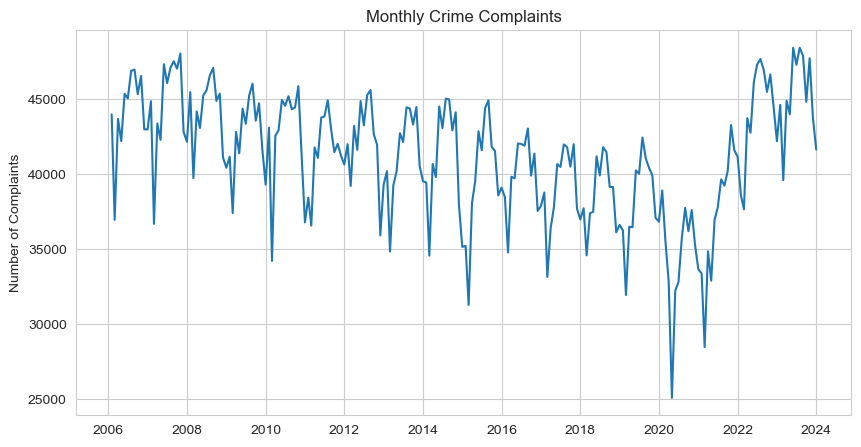

In [27]:
# Resample data to weekly and plot time series
fig, ax = plt.subplots(figsize=(10, 5))
data_monthly = data.resample('ME').count()['CMPLNT_FR_DT']
ax.plot(data_monthly.index, data_monthly.values)
ax.set_title('Monthly Crime Complaints')
ax.set_ylabel('Number of Complaints');

In [29]:
# Find min and max values
min_value = data_monthly.min()
max_value = data_monthly.max()

# Find corresponding months
min_month = data_monthly.idxmin().strftime('%Y-%m')
max_month = data_monthly.idxmax().strftime('%Y-%m')

print(f"Minimum complaints: {min_value} in {min_month}")
print(f"Maximum complaints: {max_value} in {max_month}")

Minimum complaints: 25082 in 2020-04
Maximum complaints: 48448 in 2023-05


Between the span of the years 2006 - 2023, April 2020 held the minimum number of crime complaints at 25,082. That can be attributed to the COVID pandemic causing a shut down of the city. May 2023 held the maximum number of crime complaints at 48,448. 

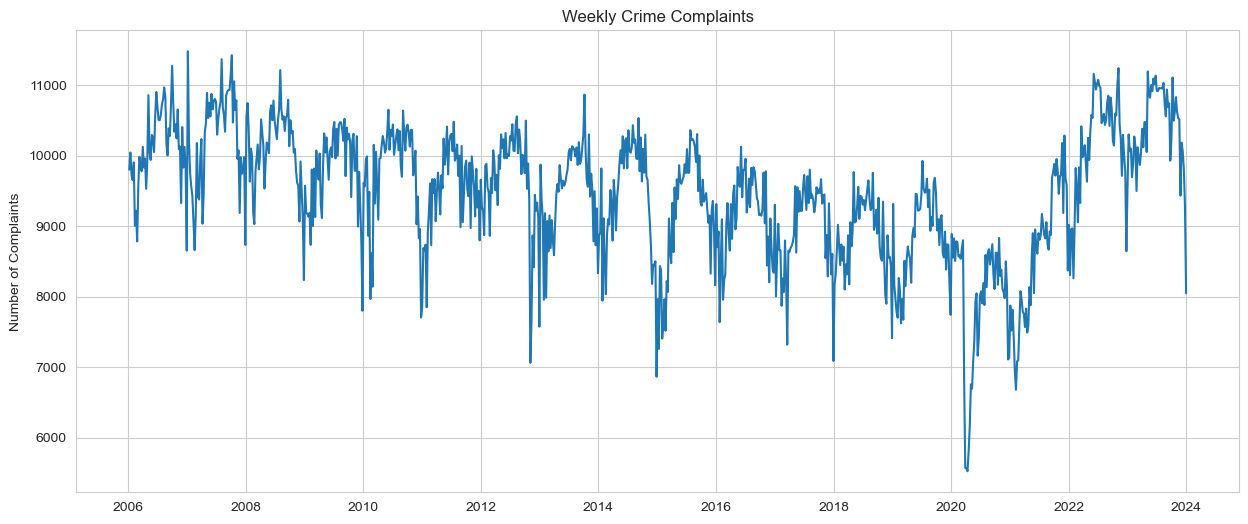

In [34]:
# Resample data to weekly and plot time series
fig, ax = plt.subplots(figsize=(15, 6))
data_weekly = data.resample('W').count()['CMPLNT_FR_DT']
data_weekly = data_weekly.iloc[1:]
ax.plot(data_weekly.index, data_weekly.values)
ax.set_title('Weekly Crime Complaints')
ax.set_ylabel('Number of Complaints');

In [35]:
# Find min and max values
min_value = data_weekly.min()
max_value = data_weekly.max()

# Find corresponding weeks
min_week = data_weekly.idxmin().strftime('%Y-%m-%d')
max_week = data_weekly.idxmax().strftime('%Y-%m-%d')

print(f"Minimum complaints: {min_value} in the week of {min_week}")
print(f"Maximum complaints: {max_value} in the week of {max_week}")

Minimum complaints: 5524 in the week of 2020-04-12
Maximum complaints: 11483 in the week of 2007-01-07


Between the span of the years 2006 - 2023, the week ending in April 12, 2020 held the minimum number of crime complaints at 5,524. The week ending in January 7, 2007 held the maximum number of crime complaints at 11,483.

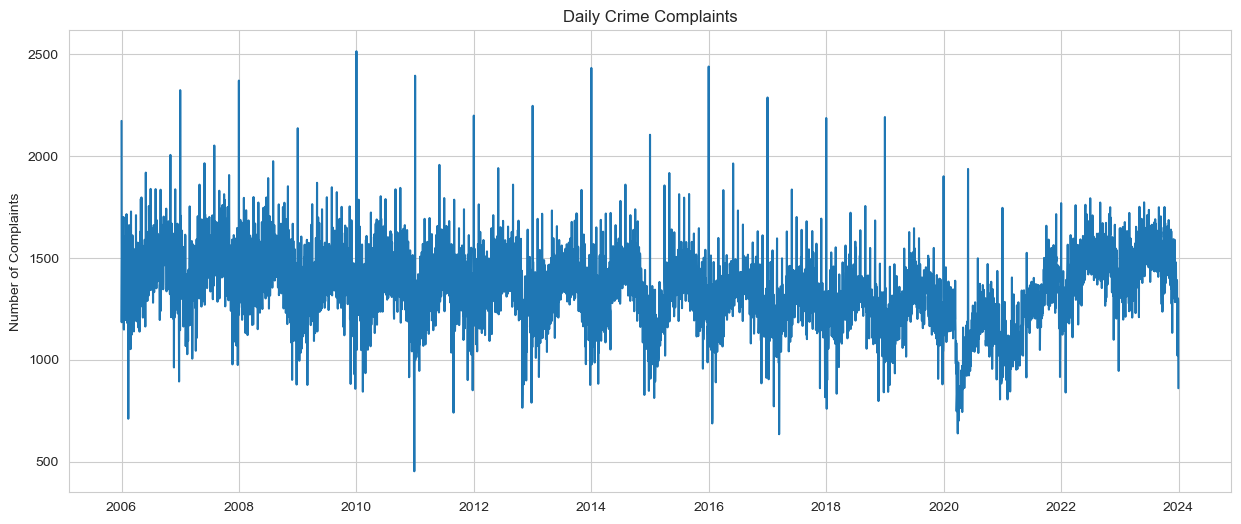

In [36]:
# Resample data to daily and plot time series
fig, ax = plt.subplots(figsize=(15, 6))
data_daily = data.resample('D').count()['CMPLNT_FR_DT']
ax.plot(data_daily.index, data_daily.values)
ax.set_title('Daily Crime Complaints')
ax.set_ylabel('Number of Complaints');

In [40]:
# Find min and max values
min_value = data_daily.min()
min_date = data_daily.idxmin()

# Find corresponding dates
max_value = data_daily.max()
max_date = data_daily.idxmax()

print(f"Minimum Complaints: {min_value} on {min_date}")
print(f"Maximum Complaints: {max_value} on {max_date}")

Minimum Complaints: 452 on 2010-12-27 00:00:00
Maximum Complaints: 2515 on 2010-01-01 00:00:00


Between the span of the years 2006 - 2023, December 27, 2010 held the minimum number of crime complaints at 452. January 1, 2010 held the maximum number of crime complaints at 2,515.

In [39]:
data_daily.describe()

count    6574.000000
mean     1352.664892
std       181.715341
min       452.000000
25%      1240.000000
50%      1357.000000
75%      1472.000000
max      2515.000000
Name: CMPLNT_FR_DT, dtype: float64

The above summary shows that the mean number of crime complaints in New York City for any given day within the years of 2006 to 2023 is 1,352 with a standard deviation of 181.7. The minimum number of crime complaints in one day is 452 and the maximum number of crim complaints in one day is 2,515.

In [41]:
# Create column to sort complaints by month
data['Month'] = data.index.month
#data_sample['Month'] = data_sample['Month'].apply(lambda x: x.month)
data.head()

,CMPLNT_NUM,CMPLNT_FR_DT,CMPLNT_FR_TM,CMPLNT_TO_DT,CMPLNT_TO_TM,ADDR_PCT_CD,RPT_DT,KY_CD,OFNS_DESC,PD_CD,...,Latitude,Longitude,Lat_Lon,PATROL_BORO,STATION_NAME,VIC_AGE_GROUP,VIC_RACE,VIC_SEX,Year,Month
CMPLNT_FR_DT,,,,,,,,,,,,,,,,,,,,,
2006-01-01,74871034,2006-01-01,13:00:00,06/01/2009,13:00:00,104.0,10/01/2010,109,GRAND LARCENY,438.0,...,40.730211,-73.900193,"(40.730211, -73.900193)",PATROL BORO QUEENS NORTH,(null),25-44,WHITE,M,2006,1
2006-01-01,10354063,2006-01-01,09:00:00,02/02/2006,10:00:00,109.0,02/09/2006,109,GRAND LARCENY,438.0,...,40.791826,-73.817909,"(40.791826, -73.817909)",PATROL BORO QUEENS NORTH,(null),45-64,WHITE HISPANIC,F,2006,1
2006-01-01,10007743,2006-01-01,15:30:00,01/04/2006,19:29:00,120.0,01/04/2006,361,OFF. AGNST PUB ORD SENSBLTY &,639.0,...,40.611535,-74.073754,"(40.611535, -74.073754)",PATROL BORO STATEN ISLAND,(null),45-64,WHITE,M,2006,1
2006-01-01,10008762,2006-01-01,01:00:00,NaN,(null),81.0,01/05/2006,578,HARRASSMENT 2,637.0,...,40.690653,-73.938073,"(40.690653, -73.938073)",PATROL BORO BKLYN NORTH,(null),25-44,BLACK,F,2006,1
2006-01-01,9934366,2006-01-01,03:00:00,NaN,(null),1.0,01/01/2006,344,ASSAULT 3 & RELATED OFFENSES,101.0,...,40.702840,-74.011919,"(40.70284, -74.011919)",PATROL BORO MAN SOUTH,(null),18-24,WHITE,M,2006,1


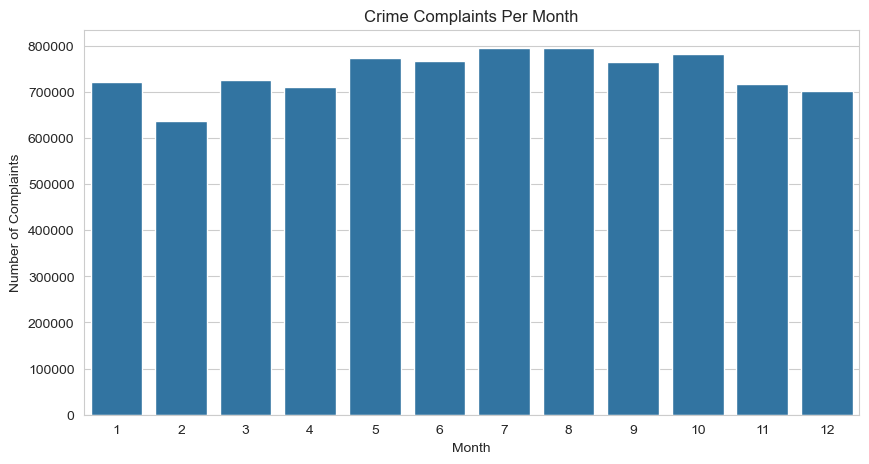

In [42]:
# Plot bar chart of number of complaints per month
x = data['Month'].value_counts().index
y = data['Month'].value_counts().values

fig, ax = plt.subplots(figsize=(10, 5))
sns.barplot(x=x, y=y)
ax.set_title('Crime Complaints Per Month')
ax.set_ylabel('Number of Complaints');

There isn't a large disparity in complaints when categorized by month. However, July and August have the largest number of crime complaints and February has the least number of crime complaints.

In [43]:
# Create column to sort complaints by weekday
data['Weekday'] = data.index.weekday
#data_sample['Month'] = data_sample['Month'].apply(lambda x: x.month)
data.head()

,CMPLNT_NUM,CMPLNT_FR_DT,CMPLNT_FR_TM,CMPLNT_TO_DT,CMPLNT_TO_TM,ADDR_PCT_CD,RPT_DT,KY_CD,OFNS_DESC,PD_CD,...,Longitude,Lat_Lon,PATROL_BORO,STATION_NAME,VIC_AGE_GROUP,VIC_RACE,VIC_SEX,Year,Month,Weekday
CMPLNT_FR_DT,,,,,,,,,,,,,,,,,,,,,
2006-01-01,74871034,2006-01-01,13:00:00,06/01/2009,13:00:00,104.0,10/01/2010,109,GRAND LARCENY,438.0,...,-73.900193,"(40.730211, -73.900193)",PATROL BORO QUEENS NORTH,(null),25-44,WHITE,M,2006,1,6
2006-01-01,10354063,2006-01-01,09:00:00,02/02/2006,10:00:00,109.0,02/09/2006,109,GRAND LARCENY,438.0,...,-73.817909,"(40.791826, -73.817909)",PATROL BORO QUEENS NORTH,(null),45-64,WHITE HISPANIC,F,2006,1,6
2006-01-01,10007743,2006-01-01,15:30:00,01/04/2006,19:29:00,120.0,01/04/2006,361,OFF. AGNST PUB ORD SENSBLTY &,639.0,...,-74.073754,"(40.611535, -74.073754)",PATROL BORO STATEN ISLAND,(null),45-64,WHITE,M,2006,1,6
2006-01-01,10008762,2006-01-01,01:00:00,NaN,(null),81.0,01/05/2006,578,HARRASSMENT 2,637.0,...,-73.938073,"(40.690653, -73.938073)",PATROL BORO BKLYN NORTH,(null),25-44,BLACK,F,2006,1,6
2006-01-01,9934366,2006-01-01,03:00:00,NaN,(null),1.0,01/01/2006,344,ASSAULT 3 & RELATED OFFENSES,101.0,...,-74.011919,"(40.70284, -74.011919)",PATROL BORO MAN SOUTH,(null),18-24,WHITE,M,2006,1,6


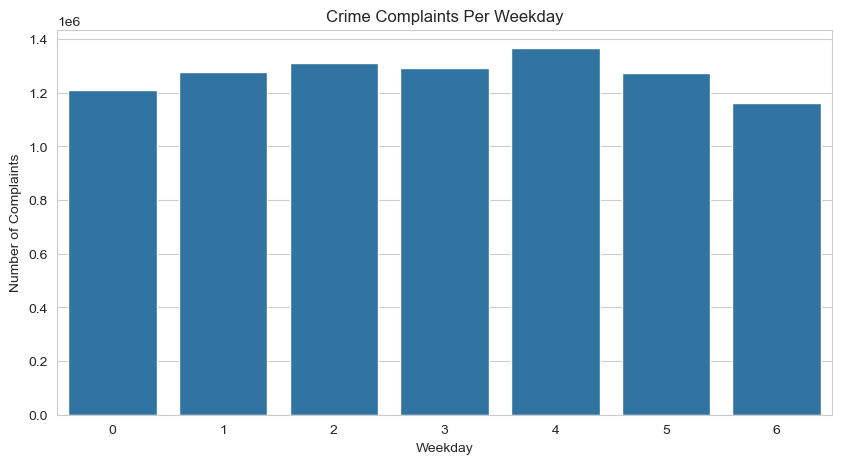

In [44]:
# Plot bar chart of number of complaints per weekday

x = data['Weekday'].value_counts().index
y = data['Weekday'].value_counts().values

fig, ax = plt.subplots(figsize=(10, 5))
sns.barplot(x=x, y=y, order=x.sort_values())
ax.set_title('Crime Complaints Per Weekday')
ax.set_ylabel('Number of Complaints');

There isn't a large disparity in crime complaints when categorized by the day of the week. However Friday has the largest number of crime complaints and Sunday has the least number of crime complaints.

In [45]:
# Create column to sort complaints by hour of occurence
data['Hour'] = data['CMPLNT_FR_TM']
data['Hour'] = data['Hour'].apply(lambda x: x[:2])
#data_sample['Month'] = data_sample['Month'].apply(lambda x: x.month)
data.head()

,CMPLNT_NUM,CMPLNT_FR_DT,CMPLNT_FR_TM,CMPLNT_TO_DT,CMPLNT_TO_TM,ADDR_PCT_CD,RPT_DT,KY_CD,OFNS_DESC,PD_CD,...,Lat_Lon,PATROL_BORO,STATION_NAME,VIC_AGE_GROUP,VIC_RACE,VIC_SEX,Year,Month,Weekday,Hour
CMPLNT_FR_DT,,,,,,,,,,,,,,,,,,,,,
2006-01-01,74871034,2006-01-01,13:00:00,06/01/2009,13:00:00,104.0,10/01/2010,109,GRAND LARCENY,438.0,...,"(40.730211, -73.900193)",PATROL BORO QUEENS NORTH,(null),25-44,WHITE,M,2006,1,6,13
2006-01-01,10354063,2006-01-01,09:00:00,02/02/2006,10:00:00,109.0,02/09/2006,109,GRAND LARCENY,438.0,...,"(40.791826, -73.817909)",PATROL BORO QUEENS NORTH,(null),45-64,WHITE HISPANIC,F,2006,1,6,09
2006-01-01,10007743,2006-01-01,15:30:00,01/04/2006,19:29:00,120.0,01/04/2006,361,OFF. AGNST PUB ORD SENSBLTY &,639.0,...,"(40.611535, -74.073754)",PATROL BORO STATEN ISLAND,(null),45-64,WHITE,M,2006,1,6,15
2006-01-01,10008762,2006-01-01,01:00:00,NaN,(null),81.0,01/05/2006,578,HARRASSMENT 2,637.0,...,"(40.690653, -73.938073)",PATROL BORO BKLYN NORTH,(null),25-44,BLACK,F,2006,1,6,01
2006-01-01,9934366,2006-01-01,03:00:00,NaN,(null),1.0,01/01/2006,344,ASSAULT 3 & RELATED OFFENSES,101.0,...,"(40.70284, -74.011919)",PATROL BORO MAN SOUTH,(null),18-24,WHITE,M,2006,1,6,03


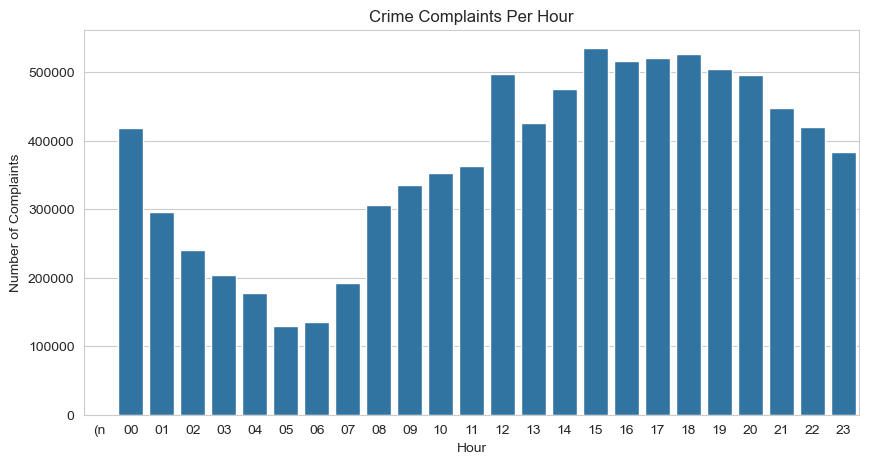

In [46]:
# Plot bar chart of number of complaints per hour

x = data['Hour'].value_counts().index
y = data['Hour'].value_counts().values

fig, ax = plt.subplots(figsize=(10, 5))
sns.barplot(x=x, y=y, order=x.sort_values())
ax.set_title('Crime Complaints Per Hour')
ax.set_ylabel('Number of Complaints');

When crime complaints are categorized by hour, 3pm has the largest number of crime complaints and 5am has the last number of crime complaints.

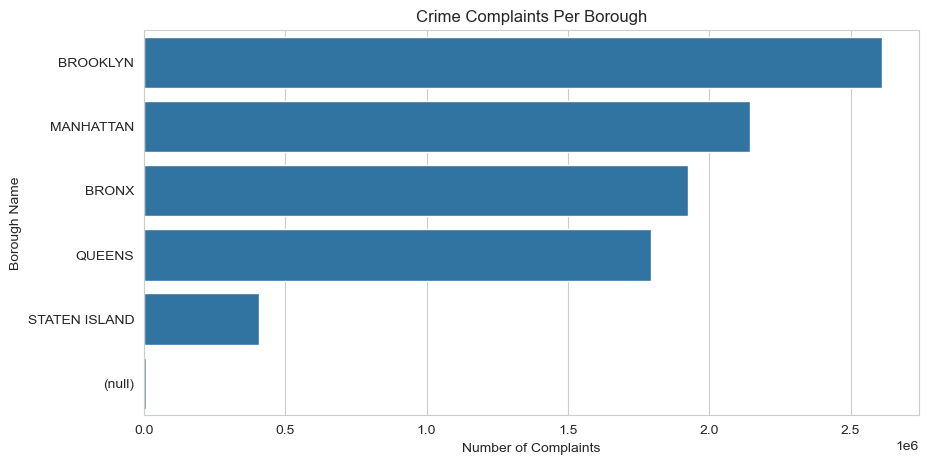

In [58]:
# Plot bar chart of number of complaints per borough

x = data['BORO_NM'].value_counts().values
y = data['BORO_NM'].value_counts().index

fig, ax = plt.subplots(figsize=(10, 5))
sns.barplot(x=x, y=y, orient='h')
ax.set_title('Crime Complaints Per Borough')
ax.set_xlabel('Number of Complaints')
ax.set_ylabel('Borough Name');

The above plot shows that Brooklyn holds the most number of crime complaints while Staten Island holds the least number of complaints.

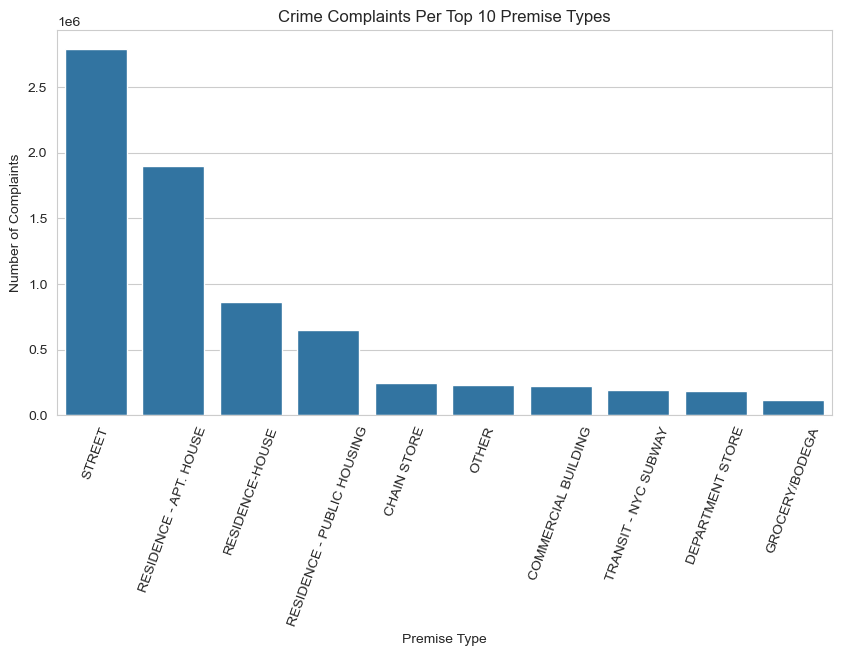

In [48]:
# Plot bar chart of number of complaints per premise type description

x = data['PREM_TYP_DESC'].value_counts().index[:10]
y = data['PREM_TYP_DESC'].value_counts().values[:10]

fig, ax = plt.subplots(figsize=(10, 5))
sns.barplot(x=x, y=y)
ax.set_title('Crime Complaints Per Top 10 Premise Types')
plt.xticks(rotation=70)
ax.set_xlabel('Premise Type')
ax.set_ylabel('Number of Complaints');

The above plot shows that most crimes reported happen on the street. However, due to issues with location data as previously stated, this may not be completely accurate.

In [49]:
data['SUSP_AGE_GROUP'].value_counts()

SUSP_AGE_GROUP
(null)     4567311
25-44      1624648
UNKNOWN    1273503
18-24       605058
45-64       565791
            ...   
1953             1
4646             1
1515             1
292              1
-956             1
Name: count, Length: 274, dtype: int64

The largest category of suspect age group is 'null'. Additionally, there are invalid values for age such as 4,646 and -956. Therefore, I cannot draw any useful conclusions from this part of the data.

In [50]:
data['SUSP_RACE'].value_counts()

SUSP_RACE
(null)                            3675010
BLACK                             1922093
UNKNOWN                           1424611
WHITE HISPANIC                     873627
WHITE                              540079
BLACK HISPANIC                     270244
ASIAN / PACIFIC ISLANDER           172013
AMERICAN INDIAN/ALASKAN NATIVE      14731
OTHER                                  11
Name: count, dtype: int64

The largest category of suspect race is 'unknown', therefore, I cannot draw any useful conclusions from this part of the data.

In [51]:
data['SUSP_SEX'].value_counts()

SUSP_SEX
(null)    3807318
M         3132206
U          995455
F          957440
Name: count, dtype: int64

In the suspect sex category, there are more unknown than female. Therefore, I cannot draw any useful conclusions from this part of the data.

In [52]:
data['VIC_AGE_GROUP'].value_counts()

VIC_AGE_GROUP
25-44      2965190
(null)     1619926
45-64      1536599
UNKNOWN    1125232
18-24       901541
            ...   
1445             1
710              1
407              1
10308            1
-46              1
Name: count, Length: 281, dtype: int64

The largest category of victim age group is the unknown and null values combined. Additionally, there are invalid values for age such as 1,445 or -46. Therefore, I cannot draw any useful conclusions from this part of the data.

In [53]:
data['VIC_RACE'].value_counts()

VIC_RACE
UNKNOWN                           2889287
BLACK                             2147434
WHITE                             1487238
WHITE HISPANIC                    1462134
ASIAN / PACIFIC ISLANDER           550287
BLACK HISPANIC                     315949
AMERICAN INDIAN/ALASKAN NATIVE      39389
(null)                                671
OTHER                                  30
Name: count, dtype: int64

The largest category of victim race is 'unknown', therefore, I cannot draw any useful conclusions from this part of the data.

In [54]:
data['VIC_SEX'].value_counts()

VIC_SEX
F         3473328
M         2962524
E         1291586
D         1158608
L            6062
(null)        308
U               3
Name: count, dtype: int64

There are invalid values for victim sex such as E, D, L, therefore, I cannot draw any useful conclusions from this part of the data.

# Modeling

I initially tried to use a time series model to predict the number of crime complains daily in the future, but was unsuccessful each time. I included all of the model iterations using time series models in case you were wondering why my final model is not a time series. Instead, my final model is a Random Forest Regressor. I did include the iterations of those models. Feel free to skip the Time Series Models section and go straight to the Random Forest Regressor section. 

## Time Series Modeling

### Train Test Split

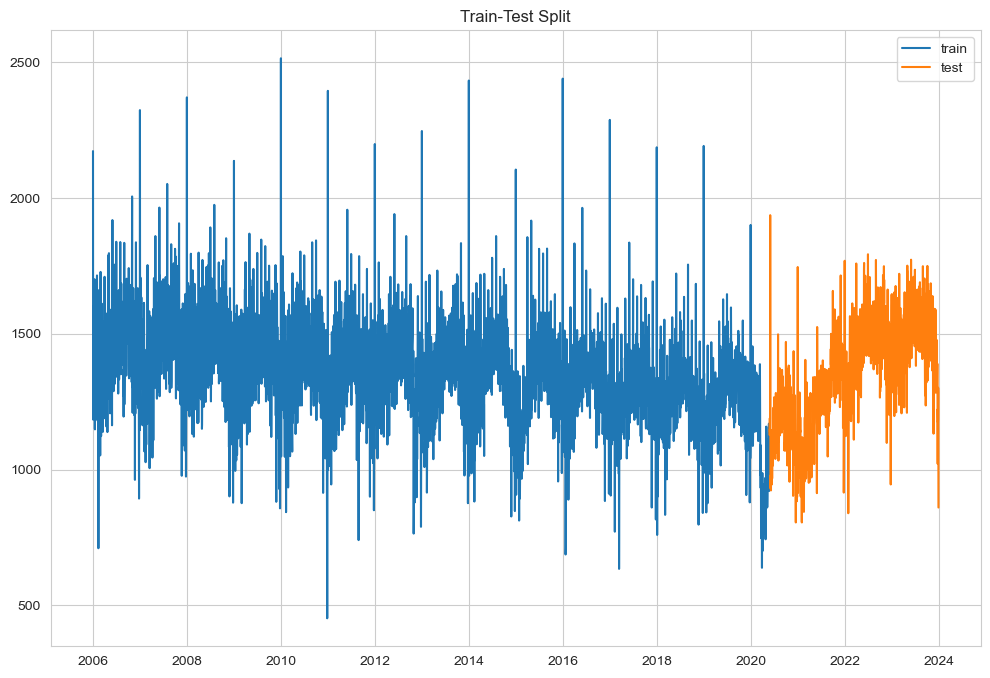

In [59]:
# Find the index which allows us to split off 20% of the data
cutoff = round(data_daily.shape[0]*0.8)

# Define train and test sets according to cutoff index above
train = data_daily[:cutoff]
test = data_daily[cutoff:]

# Plot time series with cutoff highlighted
fig, ax = plt.subplots(figsize=(12, 8))
ax.plot(train, label='train')
ax.plot(test, label='test')
ax.set_title('Train-Test Split');
plt.legend();

In [60]:
# Complete a train test split with TimeSeriesSplit
split = TimeSeriesSplit()

for train_ind, val_ind in split.split(train):
    print(f'Train index: {train_ind}')
    print(f'Test  index: {val_ind}')

Train index: [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215
 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233
 234 235 236 237 238 239 240 241 242 2

In [61]:
def display_df(dftest):
    '''
    Display the output from a Dickey-Fuller test in a more readable format
    '''
    
    
    dfoutput = pd.Series(
                dftest[0:4], 
                index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])

    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value

    display(dfoutput)
    
    print(f"The p-value associated with the Dickey-Fuller statistical test is {dfoutput['p-value']},")
    if dfoutput['p-value'] < 0.05:
        print(" so we can safely assume that the differenced data is stationary.")
    else:
        print(" so we cannot reject the null hypothesis that the differenced data is \
    not stationary.")

### Baseline Model

In [62]:
# Create baseline model with shift operator
naive = train.shift(1)
naive

CMPLNT_FR_DT
2006-01-01       NaN
2006-01-02    2173.0
2006-01-03    1184.0
2006-01-04    1352.0
2006-01-05    1485.0
               ...  
2020-05-21    1092.0
2020-05-22    1137.0
2020-05-23    1169.0
2020-05-24     953.0
2020-05-25     921.0
Freq: D, Name: CMPLNT_FR_DT, Length: 5259, dtype: float64

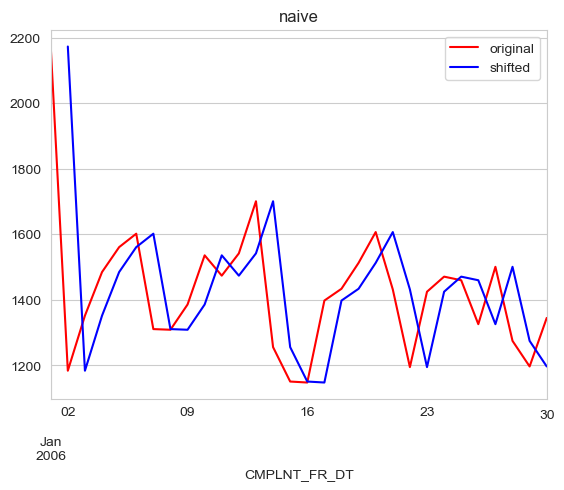

In [65]:
# Plot baseline model of beginning of train data
fig, ax = plt.subplots()

train[0:30].plot(ax=ax, c='r', label='original')
naive[0:30].plot(ax=ax, c='b', label='shifted')
ax.set_title('naive')
ax.legend();

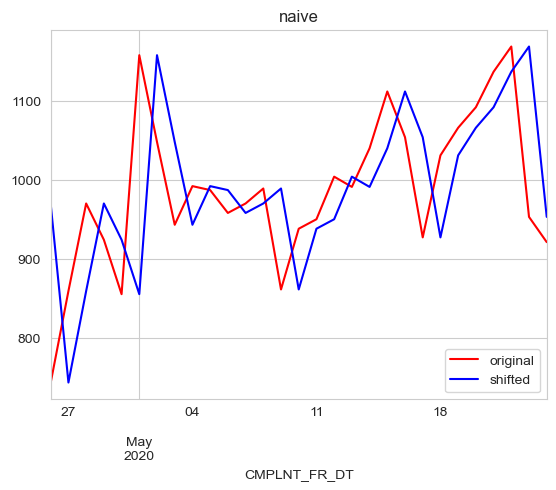

In [66]:
# Plot baseline model of end of train data
fig, ax = plt.subplots()

train[-30:-1].plot(ax=ax, c='r', label='original')
naive[-30:-1].plot(ax=ax, c='b', label='shifted')
ax.set_title('naive')
ax.legend();

In [67]:
# Calculate RMSE for baseline model
np.sqrt(mean_squared_error(train[1:], naive.dropna()))

175.30431726451732

The baseline model has a Root Mean Squared Error (RMSE) of approximately 175. This means that each prediction on avergae is off by 175 crime complaints. This is not bad, since the average nuber of complaints per day for the ata is 1,352. However this is just the train data. We will need to explore how well this baseline model predicts unseen data, our test data.

In [ ]:
# 
fig, ax = plt.subplots()
residuals = naive[1:] - train[1:]
ax.plot(residuals.index, residuals, label='resid')
ax.plot(residuals.index, residuals.rolling(30).std(), label='rolling std')
ax.legend();

In [ ]:
# 
fig, ax = plt.subplots()
ax.plot(residuals.index, residuals, label='resid')
ax.plot(residuals.index, residuals.rolling(30).var(), label='rolling var')
ax.legend();

In [ ]:
# Visualize differenced data
fig, ax = plt.subplots()
ax.plot(train.diff())
ax.set_title('Weekly differenced data');

In [ ]:
dftest = adfuller(test.diff()[1:])
display_df(dftest)

### Model Iterations

### Arima Model

In [ ]:
# ar_1 model with differencing
ar_1 = ARIMA(train, order=(1, 1, 0)).fit()

# We put a typ='levels' to convert our predictions to remove the differencing performed.
ar_1.predict(typ='levels')

In [ ]:
# Summary
ar_1.summary()

In [ ]:
# Random walk
random_walk_model = ARIMA(train, order=(0, 1, 0)).fit()
random_walk_model.summary()

In [ ]:
# Baseline ARIMA model
baseline = ARIMA(train, order=(0,0,0)).fit()
bl_preds = baseline.predict(typ='levels')
bl_rmse = np.sqrt(mean_squared_error(train, bl_preds))

In [ ]:
print(f'Baseline AIC: {baseline.aic}')
print(f'Random Walk AIC: {random_walk_model.aic}')
print(f'AR(1, 1, 0) AIC: {ar_1.aic}' )

In [ ]:
y_hat_ar1 = ar_1.predict(typ='levels')
ar1_rmse = np.sqrt(mean_squared_error(train, y_hat_ar1))

In [ ]:
y_hat_rw = random_walk_model.predict(typ='levels')
rw_rmse = np.sqrt(mean_squared_error(train, y_hat_rw))

In [ ]:
print(f'Baseline RMSE:    {bl_rmse}')
print(f'Random Walk RMSE: {rw_rmse}')
print(f'AR1 RMSE:         {ar1_rmse}')

The baseline ARIMA model has the best AIC and the best RMSE.

### Adding A Term

In [ ]:
ar_2 = ARIMA(train, order=(2, 1, 0)).fit()

ar_2.predict(typ='levels')

In [ ]:
print(baseline.aic)
print(random_walk_model.aic)
print(ar_1.aic)
print(ar_2.aic)

In [ ]:
y_hat_ar1 = ar_2.predict(typ='levels')
ar2_rmse = np.sqrt(mean_squared_error(train, y_hat_ar1))

In [ ]:
print(f'Baseline RMSE:    {bl_rmse}')
print(f'Random Walk RMSE: {rw_rmse}')
print(f'AR1 RMSE:         {ar1_rmse}')
print(f'AR2 RMSE:         {ar2_rmse}')

### Moving Average Model

In [ ]:
ma_1 = ARIMA(train, order=(0, 0, 1)).fit()
y_hat = ma_1.predict(typ='levels')
y_hat

In [ ]:
ma_1.summary()

In [ ]:
ma_1 = ARIMA(train, order=(0, 1, 1)).fit()
print(baseline.aic)
print(random_walk_model.aic)
print(ar_1.aic)
print(ar_2.aic)
print(ma_1.aic)

In [ ]:
y_hat_ar1 = ma_1.predict(typ='levels')
ma1_rmse = np.sqrt(mean_squared_error(train, y_hat_ar1))

In [ ]:
print(f'Baseline RMSE:    {bl_rmse}')
print(f'Random Walk RMSE: {rw_rmse}')
print(f'AR1 RMSE:         {ar1_rmse}')
print(f'AR2 RMSE:         {ar2_rmse}')
print(f'MA1 RMSE:         {ma1_rmse}')

In [ ]:
# MA 2 lag past 2 terms
ma_2 = ARIMA(train, order=(0, 1, 2)).fit()
y_hat = ma_2.predict(typ='levels')
y_hat

In [ ]:
print(random_walk_model.aic)
print(ar_1.aic)
print(ar_2.aic)
print(ma_1.aic)
print(ma_2.aic)

In [ ]:
y_hat_ar1 = ma_2.predict(typ='levels')
ma2_rmse = np.sqrt(mean_squared_error(train, y_hat_ar1))

In [ ]:
print(f'Baseline RMSE:    {bl_rmse}')
print(f'Random Walk RMSE: {rw_rmse}')
print(f'AR1 RMSE:         {ar1_rmse}')
print(f'AR2 RMSE:         {ar2_rmse}')
print(f'MA1 RMSE:         {ma1_rmse}')
print(f'MA2 RMSE:         {ma2_rmse}')

### ARMA

In [ ]:
arma_21 = ARIMA(train, order=(2, 1, 2)).fit()

In [ ]:
print(baseline.aic)
print(random_walk_model.aic)
print(ar_1.aic)
print(ar_2.aic)
print(ma_1.aic)
print(ma_2.aic)
print(arma_21.aic)

In [ ]:
def find_rmse(model, train_data=train):
    y_hat = model.predict(typ='levels')
    return np.sqrt(mean_squared_error(train_data, y_hat))

In [ ]:
print(find_rmse(baseline))
print(find_rmse(random_walk_model))
print(find_rmse(ar_1))
print(find_rmse(ar_2))
print(find_rmse(ma_1))
print(find_rmse(ma_2))
print(find_rmse(arma_21))

### PACF ACF

In [ ]:
plot_pacf(train);

In [ ]:
plot_pacf(train.diff().dropna());

In [ ]:
plot_acf(train);

In [ ]:
plot_acf(train.diff().dropna(), lags=100);

### SARIMA

In [ ]:
! pip install pmdarima
import warnings 
warnings.filterwarnings('ignore')

In [ ]:
from pmdarima import auto_arima

auto_model = auto_arima(train, seasonal=True, m=12, trace=True)
print(auto_model.summary())

In [ ]:
sari_mod = SARIMAX(train,
                  order=(2, 1, 3),
                  seasonal_order=(1, 0, 1, 7),
                  enforce_stationarity=False,
                  enforce_invertibility=False).fit()

In [ ]:
y_hat_train = sari_mod.predict(typ='levels')

In [ ]:
preds_sari_mod = sari_mod.predict(start=test.index[0], end=test.index[-1],typ='levels')

plt.figure(figsize=(10, 6))
plt.plot(test.index, test, label="Actual")
plt.plot(test.index, preds_sari_mod, label="Predicted", color="orange")
plt.legend()
plt.title("SARIMA Model Forecast")
plt.show()

### Test data

In [ ]:
def find_rmse_test(model, test_data=test):
    y_hat = model.predict(start=test_data.index[0], end=test_data.index[-1], typ='levels')
    return np.sqrt(mean_squared_error(test_data, y_hat))

In [ ]:
print(find_rmse_test(baseline))
print(find_rmse_test(random_walk_model))
print(find_rmse_test(ar_1))
print(find_rmse_test(ar_2))
print(find_rmse_test(ma_1))
print(find_rmse_test(ma_2))
print(find_rmse_test(arma_21))

In [ ]:
preds_random_walk_model = random_walk_model.predict(
    start=test.index[0], end=test.index[-1], typ='levels')

plt.figure(figsize=(10, 6))
plt.plot(test.index, test, label="Actual")
plt.plot(test.index, preds_random_walk_model, label="Predicted", color="orange")
plt.legend()
plt.title("Random Walk Model Forecast")
plt.show()

In [ ]:
preds_ar_2 = ar_2.predict(start=test.index[0], end=test.index[-1], typ='levels')

plt.figure(figsize=(10, 6))
plt.plot(test.index, test, label="Actual")
plt.plot(test.index, preds_ar_2, label="Predicted", color="orange")
plt.legend()
plt.title("Moving Average 1 Model Forecast")
plt.show()

In [ ]:
preds_ma_1 = ma_1.predict(start=test.index[0], end=test.index[-1], typ='levels')

plt.figure(figsize=(10, 6))
plt.plot(test.index, test, label="Actual")
plt.plot(test.index, preds_ma_1, label="Predicted", color="orange")
plt.legend()
plt.title("Moving Average 1 Model Forecast")
plt.show()

In [ ]:
preds_ma_2 = ma_2.predict(start=test.index[0], end=test.index[-1], typ='levels')

plt.figure(figsize=(10, 6))
plt.plot(test.index, test, label="Actual")
plt.plot(test.index, preds_ma_2, label="Predicted", color="orange")
plt.legend()
plt.title("Moving Average 2 Model Forecast")
plt.show()

## Final Model

ARMA

In [ ]:
len(test)

In [ ]:
predictions = arma_21.predict(start=test.index[0], end=test.index[-1], typ='levels')
len(predictions)

In [ ]:
predictions

In [ ]:
test

In [ ]:
predictions = arma_21.predict(start=test.index[0], end=test.index[-1], typ='levels')

plt.figure(figsize=(10, 6))
plt.plot(test.index, test, label="Actual")
plt.plot(test.index, predictions, label="Predicted", color="orange")
plt.legend()
plt.title("ARMA Model Forecast")
plt.show()

## Random Forest Regressor

In [ ]:
daily_df = pd.DataFrame(data_daily)

In [ ]:
daily_df

In [ ]:
# Create lag features
def create_lag_features(df, n_lags):
    for lag in range(1, n_lags + 1):
        daily_df[f'lag_{lag}'] = df['CMPLNT_FR_DT'].shift(lag)
    return daily_df

n_lags = 5  # Number of lag features (predicting using the last 5 days)
daily_df = create_lag_features(daily_df, n_lags)

# Drop rows with missing values due to shifting
daily_df = daily_df.dropna()

# Prepare the features (X) and target (y)
X = daily_df[[f'lag_{i}' for i in range(1, n_lags + 1)]]
y = daily_df['CMPLNT_FR_DT']

# Split the data into training and testing sets
train_size = int(len(daily_df) * 0.8)  # 80% for training, 20% for testing
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Train the Random Forest model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Make predictions
y_pred = rf_model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {mse}')

In [ ]:
X_test

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(X_test.index, y_test, label="Actual")
plt.plot(X_test.index, y_pred, label="Predicted", color="orange")
plt.legend()
plt.title("Random Forest")
plt.show()

In [ ]:

residuals = y_test - y_pred

sns.histplot(residuals, kde=True)
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.title('Residual Distribution')
plt.show()

In [ ]:
feature_importance = pd.Series(rf_model.feature_importances_, index=X_train.columns)
feature_importance.sort_values(ascending=False).plot(kind='bar')
plt.title('Feature Importance')
plt.show()

In [ ]:
# Define parameter distribution
param_dist = {
    'n_estimators': np.arange(50, 300, 50),
    'max_depth': [None, 10, 20, 30, 40],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt', 'log2']
}

# Initialize Randomized Search
random_search = RandomizedSearchCV(estimator=rf_model, param_distributions=param_dist, 
                                   n_iter=20, scoring='neg_mean_squared_error', 
                                   cv=5, n_jobs=-1, verbose=2, random_state=42)

# Fit the model
random_search.fit(X_train, y_train)

# Best parameters
print(f'Best parameters: {random_search.best_params_}')

# Best model
best_model = random_search.best_estimator_

In [ ]:
y_pred = best_model.predict(X_test)

rmse = mean_squared_error(y_test, y_pred, squared=False)
print(f'RMSE after tuning: {rmse}')

r2 = r2_score(y_test, y_pred)
print(f"R²: {r2}")

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(X_test.index, y_test, label="Actual")
plt.plot(X_test.index, y_pred, label="Predicted", color="orange")
plt.legend()
plt.title("Random Forest")
plt.show()

In [ ]:
X_test

In [ ]:
# Create a date range for future predictions
future_dates = pd.date_range(start='2024-01-01', periods=730, freq='D')



last_known_data = daily_df['CMPLNT_FR_DT'].iloc[-5:]  # last 5 data points

# For simplicity, let's assume you're using the last known complaints to fill lag features
future_features['lag_1'] = last_known_data.iloc[0]  # Last known value
future_features['lag_2'] = last_known_data.iloc[1]  # Second to last known value
future_features['lag_3'] = last_known_data.iloc[2]
future_features['lag_4'] = last_known_data.iloc[3]
future_features['lag_5'] = last_known_data.iloc[4]


# Assuming your model is 'rf_model' and you have the features ready for the future dates
future_predictions = rf_model.predict(future_features)

# Assume 'historical_data' contains actual data up until 2023-12-31
# 'future_predictions' contains the model predictions for 2024 onwards
plt.figure(figsize=(10, 6))

# Plot historical data
plt.plot(historical_data['Date'], historical_data['Complaints'], label='Historical Data', color='blue')

# Plot future predictions
plt.plot(future_dates, future_predictions, label='Predicted Crime Complaints', color='orange', linestyle='--')

# Label the graph
plt.title('Crime Predictions for 2024 and Beyond')
plt.xlabel('Date')
plt.ylabel('Number of Complaints')
plt.legend()

# Display the plot
plt.show()

**Metrics**:
- **RMSE**: RMSE of approximately 115 means that, on average, this model’s predictions are off by about 115 complaints per day. Since the mean daily complaints are 1352, the relative error is about 8.5% (115 / 1352 ≈ 0.08). In crime forecasting, an RMSE below 10% of the mean is generally considered good, depending on the data's variance.
- **R2**: This model is able to explain about 64% of the changes in crime complaints. This means it’s able to predict the number of complaints fairly well. The remaining 36% is due to other factors that we haven’t considered or are harder to predict, like random events or factors not included in our model. In short, 64% of the crime complaint pattern is understood by the model, and the rest is more unpredictable.

# Conclusion

## Limitations

1. **Major changes in administrations** can have a great effect on future crime. This analysis and model does not account for that. Mayor Eric Adams has appointed a new New York City Police Commissioner in November 2024 (Jessica Tisch) and President Donald Trump has taken office in January 2025.
2. The date and time of the occurence of the crime is based on when it was reported to occur. Since the complaint may not be reported at the exact time of occurence, the **dates and times may not all be completely accurate**.
3. Crime complaints which involve multiple offenses are classified according to the most serious offense. Therefore, 

## Next Steps

1. **Model Improvement**:
2. **Deployment**:
Model Deployment: If you need to make your model accessible for predictions in real-time or future data, consider deploying it using cloud services like AWS, Azure, or Google Cloud.
Visualization: Create user-friendly dashboards (e.g., with Tableau, Power BI, or Python libraries like Dash or Streamlit) that display your predictions and key insights.
Automation: Automate the data ingestion, model retraining, and prediction pipeline to make your system scalable.
3. **Long-Term Monitoring and Model Update**: 
Model Drift: Monitor your model regularly for performance degradation (model drift) over time, especially as new data comes in.
Retraining: Retrain the model periodically to incorporate new data or changes in the patterns of complaints.